# **Digit Dataset using Validation and early stopping**
## *Universidad Nacional Autónoma de México*
## **Laboratorio Avanzado de Procesamiento de Imágenes** 
(Advanced Image Processing Laboratory)

Academics:
* Dr. Boris Escalante Ramírez

### Created by: **Sebastián González Juárez**

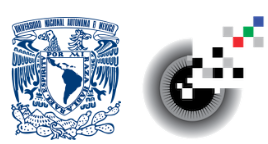

## **1) Imports.**

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as qnp
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

In [54]:
NP_SEED = 123
QNP_SEED = 123
np.random.seed(NP_SEED)
qnp.random.seed(QNP_SEED)
print(qml.__version__)

0.42.3


## **2) Global parameters and class selection.** (Editable)
In the next cell, we select which digits we want to compare:

In [55]:
CLASES = (5, 3)
TEST_SIZE = 0.2
RANDOM_STATE = 42
N_ROWS, N_COLS = 4, 4
N_QUBITS = N_ROWS * N_COLS
N_LAYERS = 4   # ajustable
LEARNING_RATE = 0.05
EPOCHS = 25
BATCH_SIZE = 32
print(f"Comparando clases: {CLASES[0]} vs {CLASES[1]}")
print(f"Qubits: {N_QUBITS} (grid {N_ROWS}x{N_COLS}), Capas HEA: {N_LAYERS}")

Comparando clases: 5 vs 3
Qubits: 16 (grid 4x4), Capas HEA: 4


## **3) 2D connectivity and brickwork pattern**.

In [56]:
def rc_to_wire(r, c, n_cols):
    return r * n_cols + c

def horizontal_edges(n_rows, n_cols, offset=0):
    edges = []
    for r in range(n_rows):
        for c in range(offset, n_cols - 1, 2):
            a = rc_to_wire(r, c, n_cols)
            b = rc_to_wire(r, c + 1, n_cols)
            edges.append((a, b))
    return edges

def vertical_edges(n_rows, n_cols, offset=0):
    edges = []
    for c in range(n_cols):
        for r in range(offset, n_rows - 1, 2):
            a = rc_to_wire(r, c, n_cols)
            b = rc_to_wire(r + 1, c, n_cols)
            edges.append((a, b))
    return edges

PATTERN = [
    ("H", 0),  # horizontales con offset 0
    ("V", 0),  # verticales   con offset 0
    ("H", 1),  # horizontales con offset 1
    ("V", 1),  # verticales   con offset 1
]

## **4) Data: digits 8×8 → 4×4 (average pooling 2×2) → angles RY.**

In [57]:
digits = load_digits()
X_imgs, y_full = digits.images, digits.target

mask = np.isin(y_full, CLASES)
X_imgs = X_imgs[mask]
y_full = y_full[mask]

y_bin = (y_full == CLASES[1]).astype(int)

def avg_pool_2x2(img_8x8):
    img = img_8x8.reshape(8, 8)
    return img.reshape(4, 2, 4, 2).mean(axis=(1, 3))

X_4x4 = np.array([avg_pool_2x2(im) for im in X_imgs])

X_min, X_max = X_4x4.min(), X_4x4.max()
X_scaled = (X_4x4 - X_min) / (X_max - X_min + 1e-8)
X_angles = np.pi * X_scaled

Stratified split: first train/test, then validation from train

In [58]:
X_tr_full, X_te, y_tr_full, y_te = train_test_split(
    X_angles, y_bin, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_bin
)

In [59]:
VALID_SIZE = 0.2  # 20% of the 'train' is used as validation

In [60]:
X_tr, X_va, y_tr, y_va = train_test_split(
    X_tr_full, y_tr_full, test_size=VALID_SIZE, random_state=RANDOM_STATE, stratify=y_tr_full
)

In [61]:
print(f"Dataset {CLASES}:")
print(f"  train={len(X_tr)}  valid={len(X_va)}  test={len(X_te)}")

Dataset (5, 3):
  train=233  valid=59  test=73


## **5) PennyLane Device and Model Helpers.**

In [62]:
try:
    dev = qml.device("lightning.qubit", wires=N_QUBITS, shots=None)
    print("Backend: lightning.qubit")
except Exception:
    dev = qml.device("default.qubit", wires=N_QUBITS, shots=None)
    print("Backend: default.qubit")

Backend: lightning.qubit


In [63]:
def feature_map_ry(angles_4x4):
    for r in range(N_ROWS):
        for c in range(N_COLS):
            w = rc_to_wire(r, c, N_COLS)
            qml.RY(angles_4x4[r, c], wires=w)

def hea_layer(params_rx, params_rz):
    # Rotaciones locales
    for q in range(N_QUBITS):
        qml.RX(params_rx[q], wires=q)
        qml.RZ(params_rz[q], wires=q)

    # Entrelazamiento por sub-patrones
    for kind, off in PATTERN:
        edges = horizontal_edges(N_ROWS, N_COLS, off) if kind == "H" \
                else vertical_edges(N_ROWS, N_COLS, off)
        for a, b in edges:
            qml.CNOT(wires=[a, b])

PARAM_SHAPE = (N_LAYERS, 2, N_QUBITS)
print("PARAM_SHAPE:", PARAM_SHAPE)

PARAM_SHAPE: (4, 2, 16)


## **6) Model QNode (Z expectation on wire 0) and utilities.**

In [64]:
@qml.qnode(dev)
def qnode_model(angles_4x4, theta):
    """
    angles_4x4: (4,4) -> RY por wire
    theta: (L, 2, N) -> por capa, Rx y Rz por qubit
    Salida: <Z_0>
    """
    feature_map_ry(angles_4x4)
    for l in range(theta.shape[0]):
        rx = theta[l, 0, :]
        rz = theta[l, 1, :]
        hea_layer(rx, rz)
    return qml.expval(qml.PauliZ(0))

def prob_y1_from_expvalZ(exp_z):
    # p(y=1) = (1 - <Z>)/2
    return (1.0 - exp_z) / 2.0

def forward_proba(theta, X):
    ps = []
    for img in X:
        ez = qnode_model(img, theta)
        ps.append(prob_y1_from_expvalZ(ez))
    return qnp.array(ps, dtype=qnp.float64)

def bce_loss(theta, Xb, yb, l2=1e-4):
    p = qnp.clip(forward_proba(theta, Xb), 1e-6, 1-1e-6)
    loss = -(yb*qnp.log(p) + (1-yb)*qnp.log(1-p)).mean()
    if l2 > 0:
        loss = loss + l2 * qnp.sum(theta*theta) / theta.size
    return loss

def accuracy(theta, Xb, yb):
    p = forward_proba(theta, Xb)
    yhat = (p >= 0.5).astype(int)
    return float(accuracy_score(yb, yhat))

## **7) Training (Adam) with mini-batches**

In [65]:
opt = qml.AdamOptimizer(stepsize=LEARNING_RATE)

In [66]:
theta = 0.1 * qnp.random.uniform(low=-1.0, high=1.0, size=PARAM_SHAPE, requires_grad=True)

In [67]:
def iterate_minibatches(X, y, batch_size, shuffle=True, seed=NP_SEED):
    rng = np.random.default_rng(seed)
    idx = np.arange(len(X))
    if shuffle:
        rng.shuffle(idx)
    for start in range(0, len(X), batch_size):
        end = start + batch_size
        sel = idx[start:end]
        yield X[sel], y[sel]

In [68]:
# Early stopping
PATIENCE = 5
best_val_loss = np.inf
best_theta = None
pat_counter = 0

In [69]:
hist = {"loss_tr": [], "loss_va": [], "acc_tr": [], "acc_va": [], "auc_va": []}

In [70]:
for epoch in range(1, EPOCHS+1):
    # ---- Entrenamiento (mini-batches) ----
    for Xb, yb in iterate_minibatches(X_tr, y_tr, BATCH_SIZE, shuffle=True, seed=epoch+NP_SEED):
        theta = opt.step(lambda th: bce_loss(th, Xb, yb), theta)

    # ---- Métricas train/valid ----
    l_tr = float(bce_loss(theta, X_tr, y_tr))
    l_va = float(bce_loss(theta, X_va, y_va))
    a_tr = accuracy(theta, X_tr, y_tr)
    a_va = accuracy(theta, X_va, y_va)

    # AUC en validación
    p_va = np.array(forward_proba(theta, X_va), dtype=float)

    if (np.unique(y_va).size == 2) and (np.std(p_va) > 1e-12):
        auc_va = roc_auc_score(y_va, p_va)
    else:
        auc_va = np.nan  # no se puede calcular AUC en esta época

    hist["loss_tr"].append(l_tr)
    hist["loss_va"].append(l_va)
    hist["acc_tr"].append(a_tr)
    hist["acc_va"].append(a_va)
    hist["auc_va"].append(auc_va)

    print(f"Epoch {epoch:02d} | "
          f"loss_tr={l_tr:.4f} acc_tr={a_tr:.3f} | "
          f"loss_va={l_va:.4f} acc_va={a_va:.3f} AUC_va={auc_va:.3f}")

    # ---- Early stopping ----
    if l_va + 1e-7 < best_val_loss:  # mejora estricta
        best_val_loss = l_va
        best_theta = qnp.array(theta)  # copia
        pat_counter = 0
    else:
        pat_counter += 1
        if pat_counter >= PATIENCE:
            print(f"\nEarly stopping activado (sin mejora {PATIENCE} épocas).")
            break

Epoch 01 | loss_tr=0.9710 acc_tr=0.498 | loss_va=0.9523 acc_va=0.508 AUC_va=0.624
Epoch 02 | loss_tr=0.7051 acc_tr=0.498 | loss_va=0.7016 acc_va=0.508 AUC_va=0.759
Epoch 03 | loss_tr=0.5957 acc_tr=0.871 | loss_va=0.6064 acc_va=0.864 AUC_va=0.929
Epoch 04 | loss_tr=0.4373 acc_tr=0.961 | loss_va=0.4523 acc_va=0.932 AUC_va=0.974
Epoch 05 | loss_tr=0.3420 acc_tr=0.953 | loss_va=0.3643 acc_va=0.932 AUC_va=0.964
Epoch 06 | loss_tr=0.3107 acc_tr=0.970 | loss_va=0.3380 acc_va=0.966 AUC_va=0.968
Epoch 07 | loss_tr=0.2737 acc_tr=0.966 | loss_va=0.3039 acc_va=0.949 AUC_va=0.971
Epoch 08 | loss_tr=0.2547 acc_tr=0.966 | loss_va=0.2881 acc_va=0.949 AUC_va=0.975
Epoch 09 | loss_tr=0.2320 acc_tr=0.961 | loss_va=0.2665 acc_va=0.949 AUC_va=0.974
Epoch 10 | loss_tr=0.2187 acc_tr=0.966 | loss_va=0.2564 acc_va=0.949 AUC_va=0.974
Epoch 11 | loss_tr=0.2101 acc_tr=0.974 | loss_va=0.2490 acc_va=0.966 AUC_va=0.975
Epoch 12 | loss_tr=0.2019 acc_tr=0.961 | loss_va=0.2401 acc_va=0.949 AUC_va=0.975
Epoch 13 | loss_

In [71]:
theta_star = best_theta if best_theta is not None else theta

## **8) Train vs. valid curves to detect overfitting**

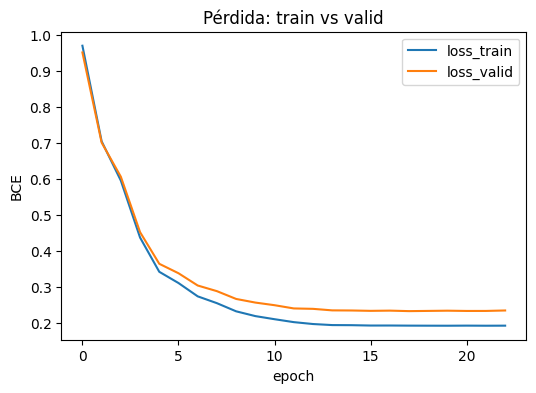

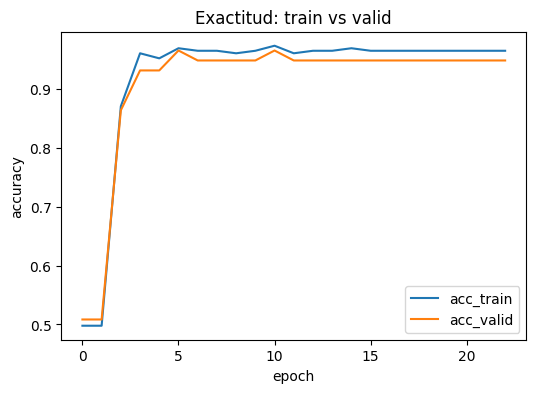

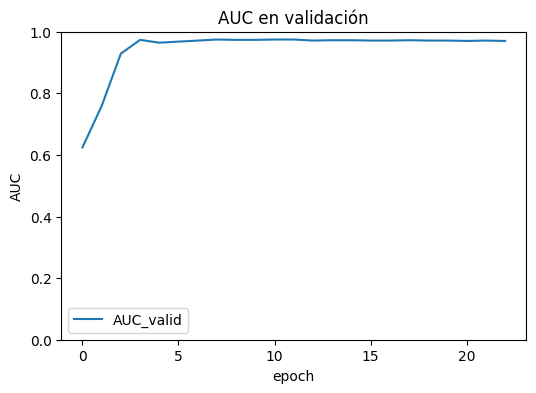

In [72]:
plt.figure(figsize=(6,4))
plt.plot(hist["loss_tr"], label="loss_train")
plt.plot(hist["loss_va"], label="loss_valid")
plt.xlabel("epoch"); plt.ylabel("BCE"); plt.title("Pérdida: train vs valid")
plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(hist["acc_tr"], label="acc_train")
plt.plot(hist["acc_va"], label="acc_valid")
plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.title("Exactitud: train vs valid")
plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(hist["auc_va"], label="AUC_valid")
plt.xlabel("epoch"); plt.ylabel("AUC"); plt.title("AUC en validación")
plt.ylim(0.0, 1.0)
plt.legend(); plt.show()


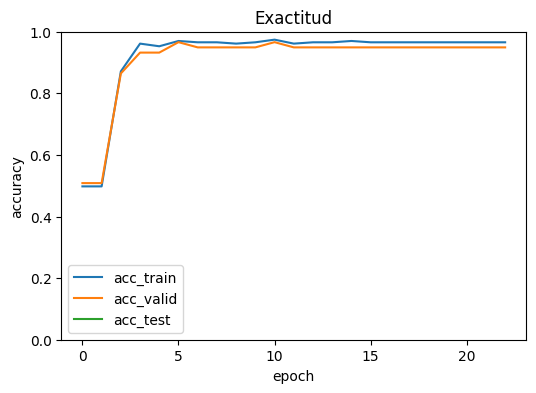

In [73]:
plt.figure(figsize=(6,4))
plt.plot(hist["acc_tr"], label="acc_train")
plt.plot(hist["acc_va"], label="acc_valid")
plt.plot(hist.get("acc_te", []), label="acc_test")  # puede faltar si no lo calculas por época
plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.title("Exactitud")
plt.ylim(0.0, 1.0); plt.legend(); plt.show()

# AUC
if "auc_te" in hist:
    plt.figure(figsize=(6,4))
    plt.plot(hist["auc_va"], label="AUC_valid")
    plt.plot(hist["auc_te"], label="AUC_test")
    plt.xlabel("epoch"); plt.ylabel("AUC"); plt.title("AUC")
    plt.ylim(0.0, 1.0); plt.legend(); plt.show()


## **9) Final evaluation using the best theta**

In [74]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve

# VALID
probs_va = np.array(forward_proba(theta_star, X_va), dtype=float)
yhat_va = (probs_va >= 0.5).astype(int)
print("Valid — Matriz de confusión:")
print(confusion_matrix(y_va, yhat_va))
print("\nValid — Reporte de clasificación:")
print(classification_report(y_va, yhat_va, target_names=[f"{CLASES[0]}→0", f"{CLASES[1]}→1"]))
print(f"Valid — AUC: {roc_auc_score(y_va, probs_va):.3f}")

# TEST
probs_te = np.array(forward_proba(theta_star, X_te), dtype=float)
yhat_te = (probs_te >= 0.5).astype(int)
print("\nTest — Matriz de confusión:")
print(confusion_matrix(y_te, yhat_te))
print("\nTest — Reporte de clasificación:")
print(classification_report(y_te, yhat_te, target_names=[f"{CLASES[0]}→0", f"{CLASES[1]}→1"]))
print(f"Test — AUC: {roc_auc_score(y_te, probs_te):.3f}")


Valid — Matriz de confusión:
[[29  1]
 [ 2 27]]

Valid — Reporte de clasificación:
              precision    recall  f1-score   support

         5→0       0.94      0.97      0.95        30
         3→1       0.96      0.93      0.95        29

    accuracy                           0.95        59
   macro avg       0.95      0.95      0.95        59
weighted avg       0.95      0.95      0.95        59

Valid — AUC: 0.972

Test — Matriz de confusión:
[[36  0]
 [ 4 33]]

Test — Reporte de clasificación:
              precision    recall  f1-score   support

         5→0       0.90      1.00      0.95        36
         3→1       1.00      0.89      0.94        37

    accuracy                           0.95        73
   macro avg       0.95      0.95      0.95        73
weighted avg       0.95      0.95      0.95        73

Test — AUC: 0.985
